<a href="https://colab.research.google.com/github/jhuarancca/Data-Science-for-Healthcare-Claims-data/blob/main/Medical_treatment_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading all required packages
# If any of it fails, do not panic. Just install it using "pip3 install <package_name>" or by using conda install package_name
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [ ]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training_variants')
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [ ]:
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


In [ ]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [ ]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [ ]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [ ]:
# Clecking column in above data set
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [ ]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


In [ ]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1503 non-null   int64 
 1   TEXT    1500 non-null   object
dtypes: int64(1), object(1)
memory usage: 23.6+ KB


In [ ]:
data_text.describe()

,ID
count,1503.000000
mean,751.000000
std,434.023041
min,0.000000
25%,375.500000
50%,751.000000
75%,1126.500000
max,1502.000000


In [ ]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [ ]:
# checking the dimentions
data_text.shape

(1503, 2)

In [ ]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
import nltk
nltk.download('stopwords')
# We would like to remove all stop words like a, is, an, the, ... 
# so we collecting all of them from nltk library
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [ ]:
# Below code will take some time because its huge text (took 4 minute on my 16 GB RAM system), so run it and have a cup of coffee :)
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

In [ ]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1503,1503,FGFR4,Amplification,7,NaN
1504,1504,KDM6A,Deletion,1,NaN
...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,NaN
3317,3317,RUNX1,A122*,1,NaN
3318,3318,RUNX1,Fusions,1,NaN
3319,3319,RUNX1,R80C,4,NaN


In [ ]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [ ]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


In [ ]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [ ]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [ ]:
X_train

,ID,Gene,Variation,Class,TEXT
1968,1968,CTNNB1,D32N,7,CTNNB1 D32N
364,364,EPAS1,P531S,2,hypoxia inducible factors hifs transcription f...
1057,1057,EWSR1,EWSR1-FEV_Fusion,2,result chromosome translocations ews gene fuse...
2478,2478,BRCA1,F1734S,1,BRCA1 F1734S
2489,2489,BRCA1,G1706A,3,BRCA1 G1706A
...,...,...,...,...,...
2842,2842,BRCA2,V2908G,5,BRCA2 V2908G
1519,1519,ALK,Y1278S,7,ALK Y1278S
339,339,ROS1,E1935G,2,rapidly growing recognition role oncogenic ros...
40,40,DICER1,D1810A,4,human dicer contains two rnase iii domains rna...


In [ ]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [ ]:
import pandas as pd
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [ ]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

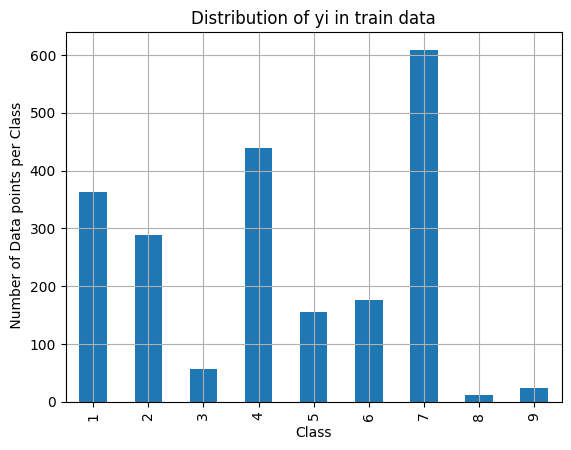

In [ ]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [ ]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


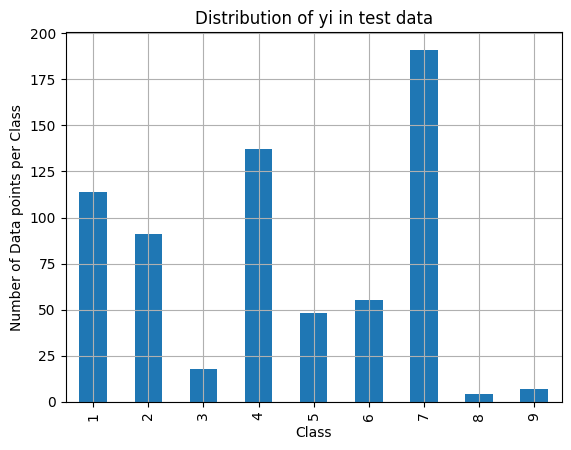

In [ ]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [ ]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


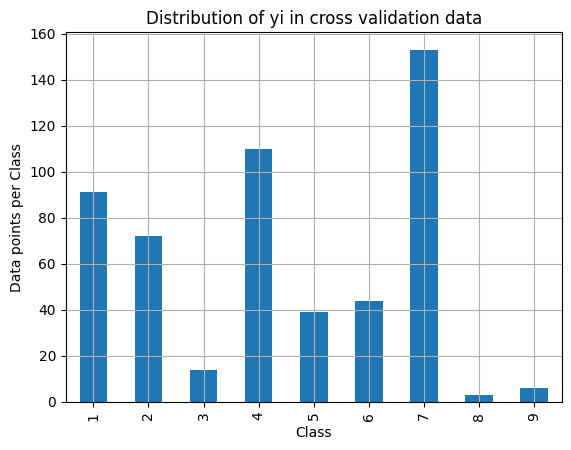

In [ ]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [ ]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [ ]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [ ]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.5326042348442956


In [ ]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.474067295628949


In [ ]:
# Lets get the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

In [ ]:
# Lets see the output. these will be 665 values present in test dataset
predicted_y

array([7, 4, 7, 8, 6, 2, 8, 6, 2, 1, 3, 5, 0, 8, 8, 5, 3, 3, 6, 5, 1, 3,
       8, 7, 1, 8, 2, 1, 4, 2, 5, 8, 1, 6, 2, 1, 5, 3, 2, 2, 8, 0, 3, 5,
       1, 8, 1, 8, 6, 8, 8, 6, 1, 6, 8, 4, 2, 3, 0, 6, 8, 1, 4, 4, 7, 6,
       4, 7, 2, 4, 3, 4, 7, 4, 1, 1, 0, 6, 8, 6, 8, 0, 4, 6, 6, 6, 4, 1,
       0, 3, 5, 4, 4, 0, 0, 7, 5, 6, 4, 7, 6, 6, 2, 5, 0, 8, 8, 3, 0, 6,
       7, 0, 7, 3, 8, 6, 0, 5, 1, 7, 8, 5, 6, 6, 5, 2, 3, 7, 0, 3, 7, 1,
       7, 6, 2, 1, 0, 3, 2, 7, 1, 8, 7, 7, 3, 6, 6, 3, 7, 0, 8, 6, 5, 0,
       6, 2, 2, 2, 7, 7, 7, 5, 0, 6, 8, 6, 2, 6, 0, 7, 5, 0, 1, 6, 8, 6,
       6, 2, 0, 6, 0, 7, 8, 6, 5, 8, 2, 2, 8, 6, 4, 5, 2, 3, 4, 0, 1, 6,
       8, 7, 7, 2, 8, 1, 1, 3, 6, 2, 3, 7, 6, 3, 3, 3, 4, 6, 8, 7, 5, 4,
       7, 5, 5, 8, 1, 2, 7, 8, 3, 3, 5, 8, 1, 3, 6, 3, 6, 6, 4, 1, 5, 0,
       1, 7, 6, 6, 0, 5, 8, 5, 2, 8, 5, 7, 5, 1, 0, 5, 7, 5, 3, 6, 2, 7,
       6, 6, 4, 8, 6, 7, 1, 1, 5, 1, 8, 5, 8, 2, 8, 3, 8, 4, 7, 6, 5, 3,
       2, 6, 1, 4, 0, 6, 5, 6, 4, 6, 4, 0, 3, 1, 6,

In [ ]:
predicted_y = predicted_y + 1

In [ ]:
C = confusion_matrix(y_test, predicted_y)


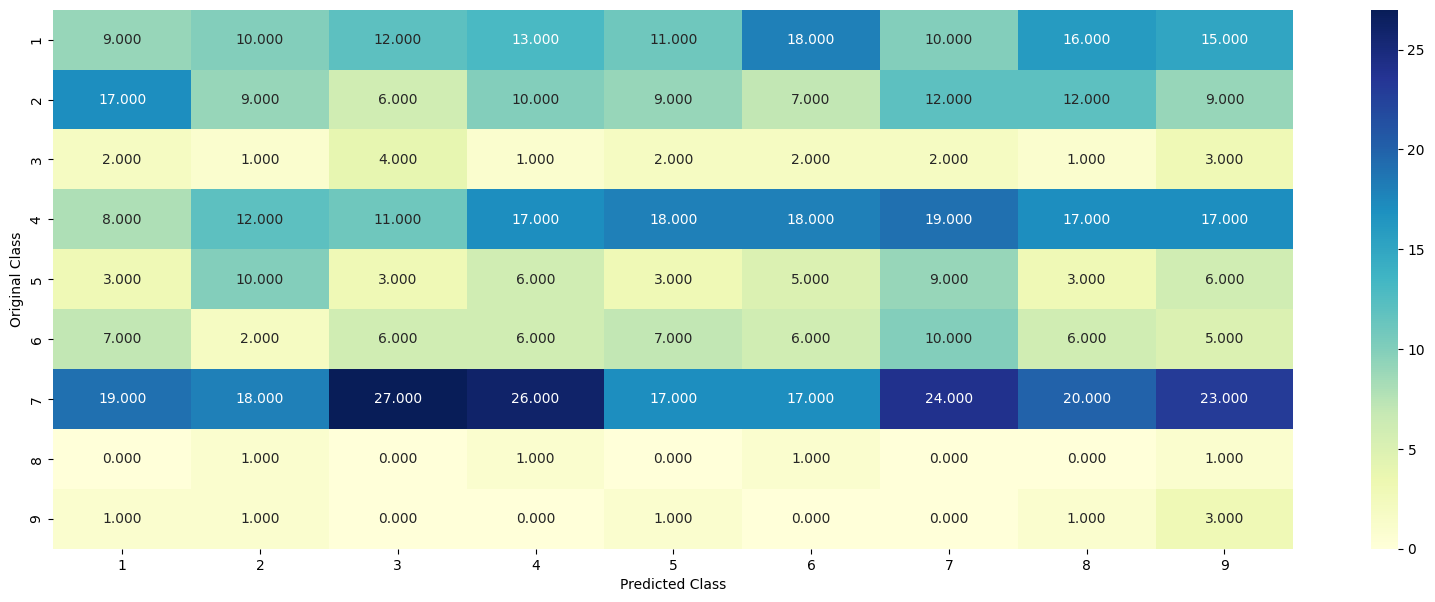

In [ ]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
B =(C/C.sum(axis=0))

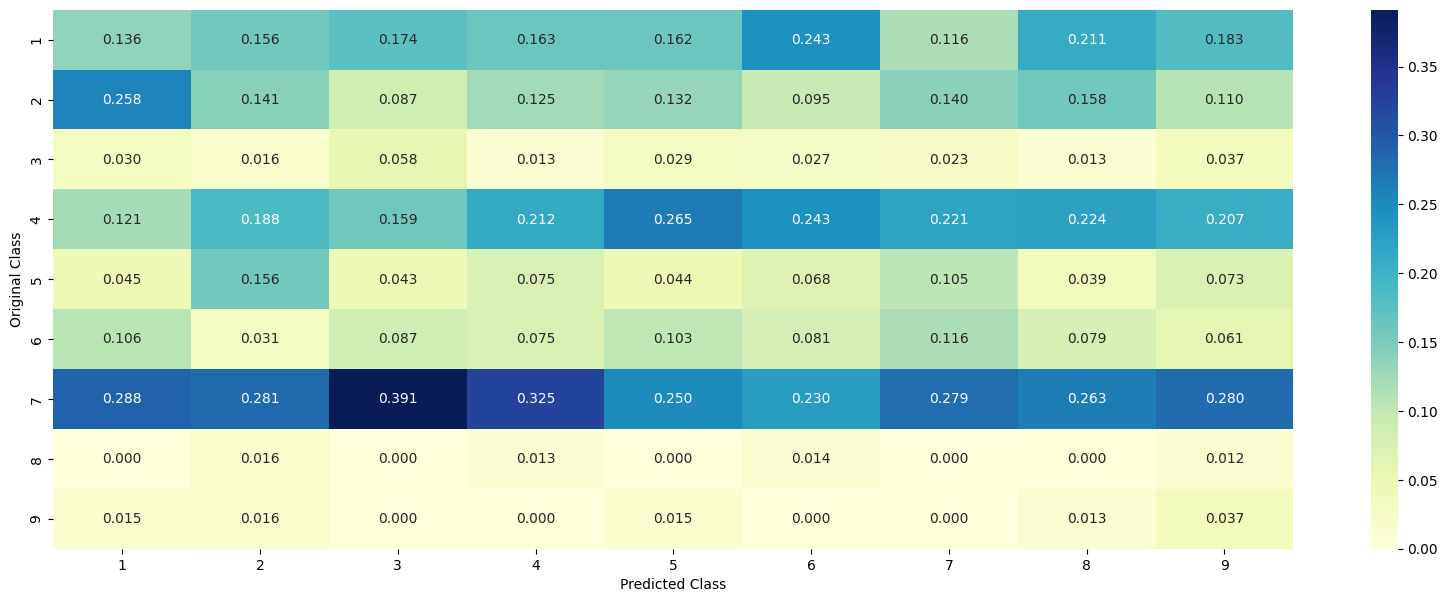

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
A =(((C.T)/(C.sum(axis=1))).T)

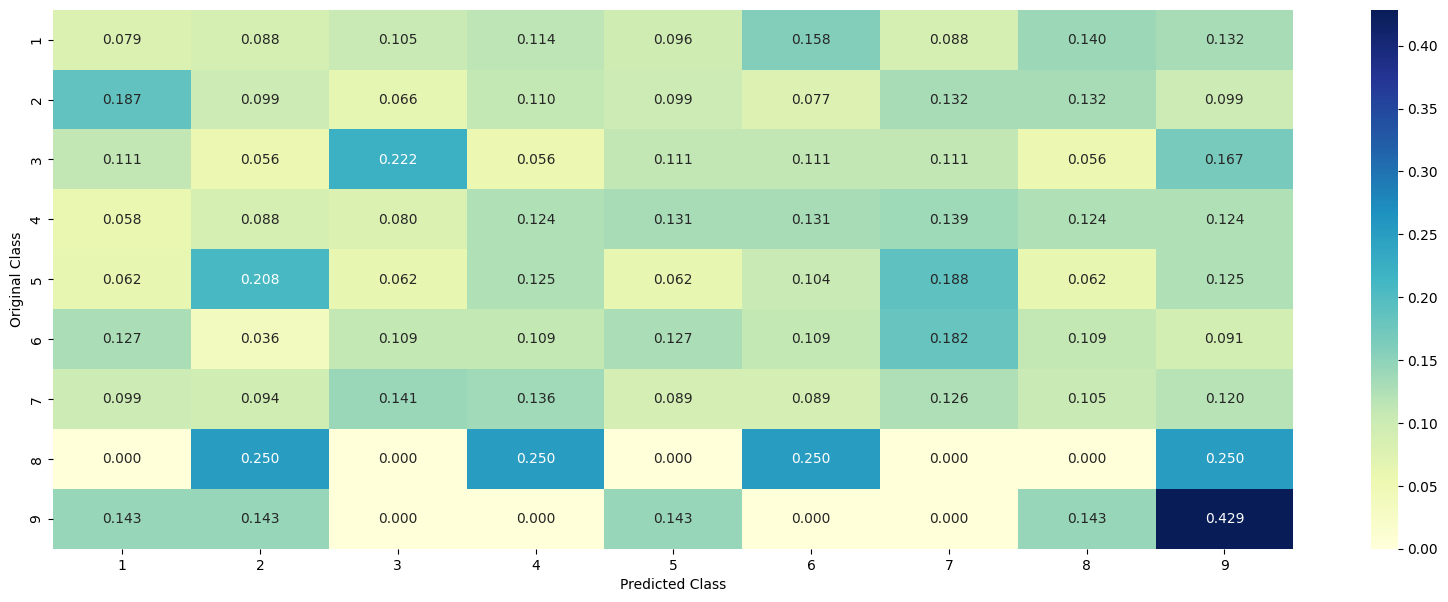

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 231
BRCA1     163
EGFR       94
TP53       93
BRCA2      85
PTEN       82
KIT        69
BRAF       57
ERBB2      49
ALK        47
PDGFRA     43
Name: Gene, dtype: int64


In [ ]:
unique_genes.shape[0]

231

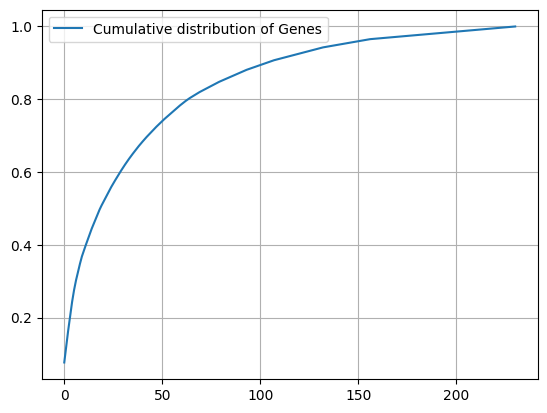

In [ ]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [ ]:
train_gene_feature_onehotCoding.shape

(2124, 230)

In [ ]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1b', 'arid2', 'arid5b', 'asxl2', 'atm', 'atr',
       'atrx', 'aurka', 'axin1', 'axl', 'b2m', 'bap1', 'bard1', 'bcl10',
       'bcl2', 'bcl2l11', 'bcor', 'braf', 'brca1', 'brca2', 'brd4',
       'brip1', 'btk', 'card11', 'carm1', 'casp8', 'cbl', 'ccnd1',
       'ccnd2', 'ccnd3', 'ccne1', 'cdh1', 'cdk12', 'cdk4', 'cdk6', 'cdk8',
       'cdkn1a', 'cdkn1b', 'cdkn2a', 'cdkn2b', 'cdkn2c', 'cebpa', 'chek2',
       'cic', 'crebbp', 'ctcf', 'ctla4', 'ctnnb1', 'ddr2', 'dicer1',
       'dnmt3a', 'dnmt3b', 'dusp4', 'egfr', 'elf3', 'ep300', 'epas1',
       'erbb2', 'erbb3', 'erbb4', 'ercc2', 'ercc4', 'erg', 'errfi1',
       'esr1', 'etv6', 'ewsr1', 'ezh2', 'fam58a', 'fanca', 'fat1',
       'fbxw7', 'fgfr1', 'fgfr2', 'fgfr3', 'fgfr4', 'flt3', 'foxa1',
       'foxp1', 'gata3', 'gna11', 'gnaq', 'gnas', 'h3f3a', 'hist1h1c',
       'hla', 'hnf1a', 'hras', 'idh1', 'idh2', 'igf1r', 'ikbke', 'ikzf1',
       'in

In [ ]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [ ]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [ ]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [ ]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [ ]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.2673144013672952
For values of alpha =  0.0001 The log loss is: 1.2268109290354232
For values of alpha =  0.001 The log loss is: 1.2449765561497532
For values of alpha =  0.01 The log loss is: 1.3469354760317875
For values of alpha =  0.1 The log loss is: 1.4446986006441602
For values of alpha =  1 The log loss is: 1.4763264742763313


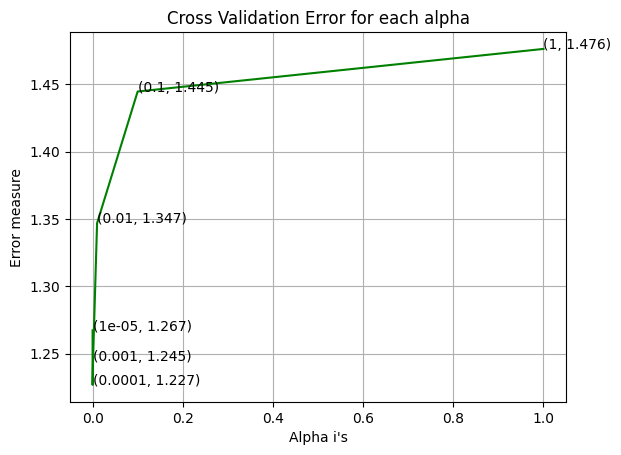

In [ ]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.9758486526053269
For values of best alpha =  0.0001 The cross validation log loss is: 1.2268109290354232
For values of best alpha =  0.0001 The test log loss is: 1.2076056790945033


In [ ]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [ ]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 640 out of 665 : 96.2406015037594
2. In cross validation data 515 out of  532 : 96.80451127819549


In [ ]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1941
Truncating_Mutations    59
Deletion                48
Amplification           37
Fusions                 21
Q61H                     3
Q61R                     3
Overexpression           3
T167A                    2
T73I                     2
G13V                     2
Name: Variation, dtype: int64


[0.02777778 0.05037665 0.06779661 ... 0.99905838 0.99952919 1.        ]


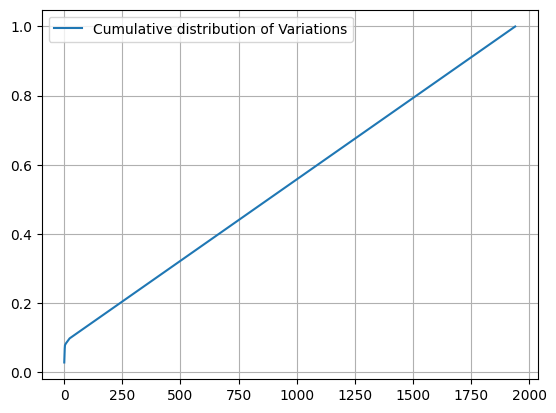

In [ ]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [ ]:
train_variation_feature_onehotCoding.shape

(2124, 1971)

In [ ]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [ ]:
train_variation_feature_responseCoding.shape

(2124, 9)

In [ ]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [ ]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.6989216299502996
For values of alpha =  0.0001 The log loss is: 1.6884414034030713
For values of alpha =  0.001 The log loss is: 1.6936866297990114
For values of alpha =  0.01 The log loss is: 1.70476200293881
For values of alpha =  0.1 The log loss is: 1.7072553855042492
For values of alpha =  1 The log loss is: 1.7085574933789445


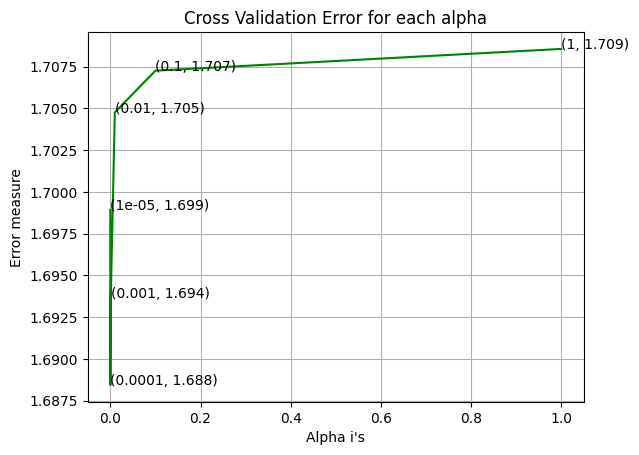

In [ ]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.6707723184721518
For values of best alpha =  0.0001 The cross validation log loss is: 1.6884414034030713
For values of best alpha =  0.0001 The test log loss is: 1.710866087309447


In [ ]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [ ]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 67 out of 665 : 10.075187969924812
2. In cross validation data 69 out of  532 : 12.969924812030076


In [ ]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [ ]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [ ]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 32516


In [ ]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [ ]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [ ]:

# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [ ]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:

sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [ ]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 2886, 4: 1994, 5: 1723, 6: 1620, 8: 1469, 7: 1206, 9: 1047, 11: 908, 10: 863, 12: 828, 15: 643, 13: 594, 14: 558, 16: 546, 18: 429, 17: 419, 19: 409, 20: 379, 24: 357, 22: 329, 21: 327, 23: 255, 25: 244, 30: 234, 26: 217, 28: 213, 29: 197, 32: 196, 27: 196, 36: 195, 33: 186, 34: 176, 31: 175, 39: 159, 35: 155, 40: 134, 38: 134, 48: 125, 37: 125, 42: 120, 45: 118, 43: 118, 41: 117, 44: 109, 46: 102, 49: 88, 54: 86, 47: 85, 51: 84, 55: 82, 50: 80, 53: 78, 52: 78, 60: 77, 58: 77, 56: 77, 57: 75, 68: 72, 66: 72, 61: 70, 72: 69, 84: 62, 75: 62, 74: 62, 77: 61, 76: 59, 70: 59, 64: 59, 63: 59, 65: 58, 59: 57, 62: 54, 69: 52, 99: 51, 80: 51, 94: 49, 86: 49, 78: 48, 82: 47, 81: 47, 67: 47, 87: 46, 79: 46, 91: 45, 88: 45, 73: 44, 92: 43, 71: 43, 110: 42, 85: 42, 102: 41, 101: 41, 100: 41, 89: 41, 114: 40, 98: 39, 95: 39, 123: 37, 112: 37, 83: 37, 97: 36, 109: 35, 90: 35, 126: 34, 107: 34, 96: 34, 119: 33, 108: 33, 111: 31, 104: 31, 144: 30, 106: 30, 103: 30, 93: 30, 130: 29, 118: 29,

**Naive Bayes**

In [ ]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.6181460443186977
For values of alpha =  0.0001 The log loss is: 1.5632597964898434
For values of alpha =  0.001 The log loss is: 1.5588352971964048
For values of alpha =  0.01 The log loss is: 1.5904241178452188
For values of alpha =  0.1 The log loss is: 1.6966843718514046
For values of alpha =  1 The log loss is: 1.7809177244731573


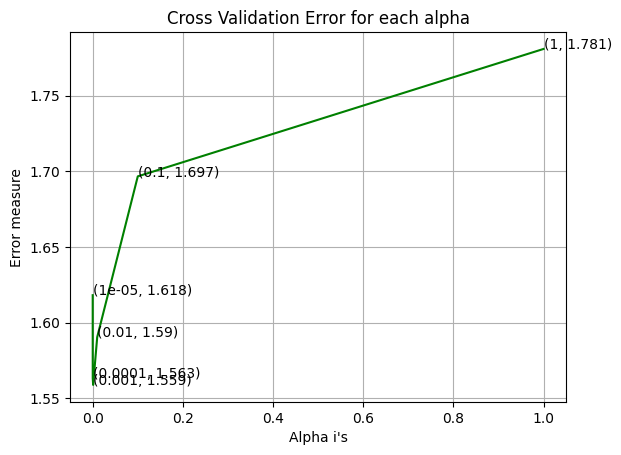

In [ ]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 1.2677847239104618
For values of best alpha =  0.001 The cross validation log loss is: 1.5588352971964048
For values of best alpha =  0.001 The test log loss is: 1.5812639342584303


In [ ]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [ ]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.127 % of word of test data appeared in train data
96.087 % of word of Cross Validation appeared in train data


In [ ]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [ ]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [ ]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 34717)
(number of data points * number of features) in test data =  (665, 34717)
(number of data points * number of features) in cross validation data = (532, 34717)


In [ ]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.3385492959205685
for alpha = 0.0001
Log Loss : 1.3344924351487355
for alpha = 0.001
Log Loss : 1.3302244163290862
for alpha = 0.1
Log Loss : 1.323728261378903
for alpha = 1
Log Loss : 1.3255202111318454
for alpha = 10
Log Loss : 1.4710939795166809
for alpha = 100
Log Loss : 1.519609803495522
for alpha = 1000
Log Loss : 1.4984608890871565


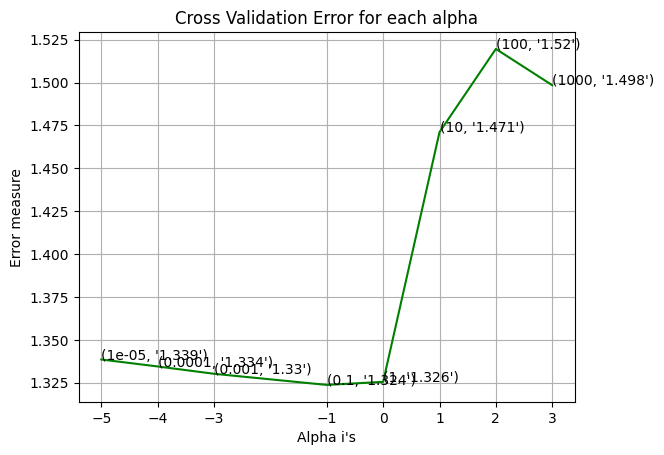

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.1 The train log loss is: 0.7417544891268849
For values of best alpha =  0.1 The cross validation log loss is: 1.323728261378903
For values of best alpha =  0.1 The test log loss is: 1.3690373057540008


Log Loss:  1.323728261378903
Number of missClassified point:  0.4323308270676692
-------------------- Confusion matrix --------------------


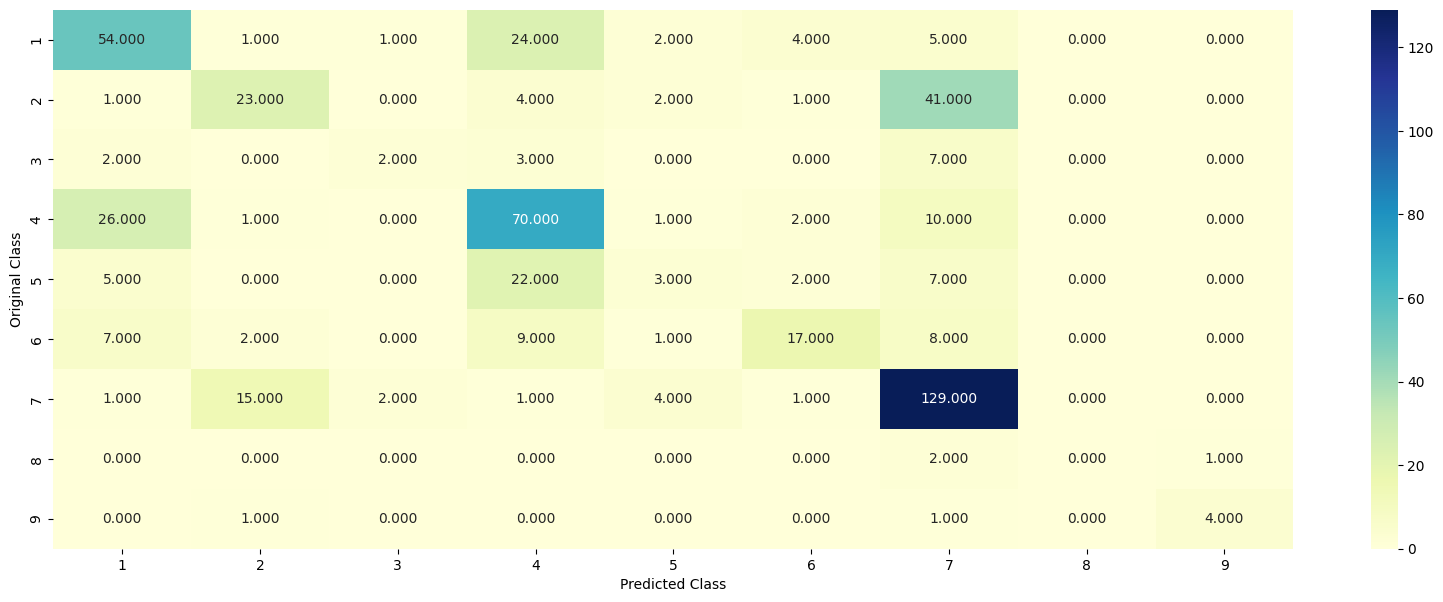

-------------------- Precision matrix (Columm Sum=1) --------------------


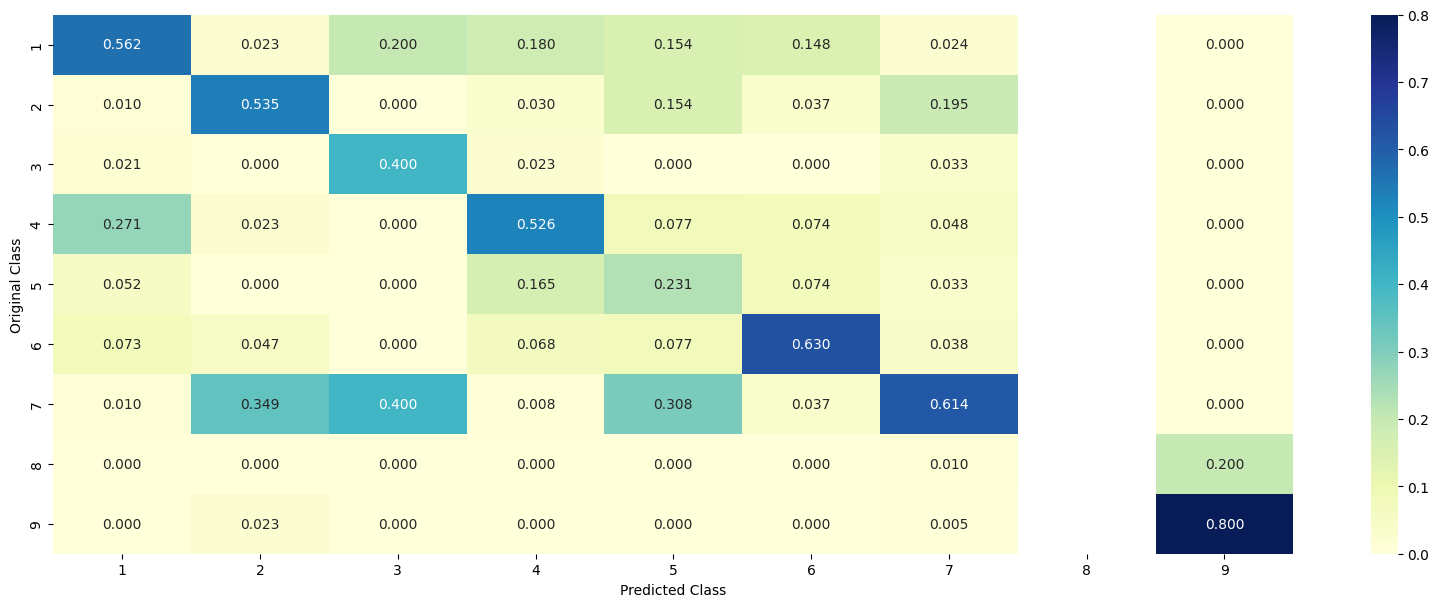

-------------------- Recall matrix (Row sum=1) --------------------


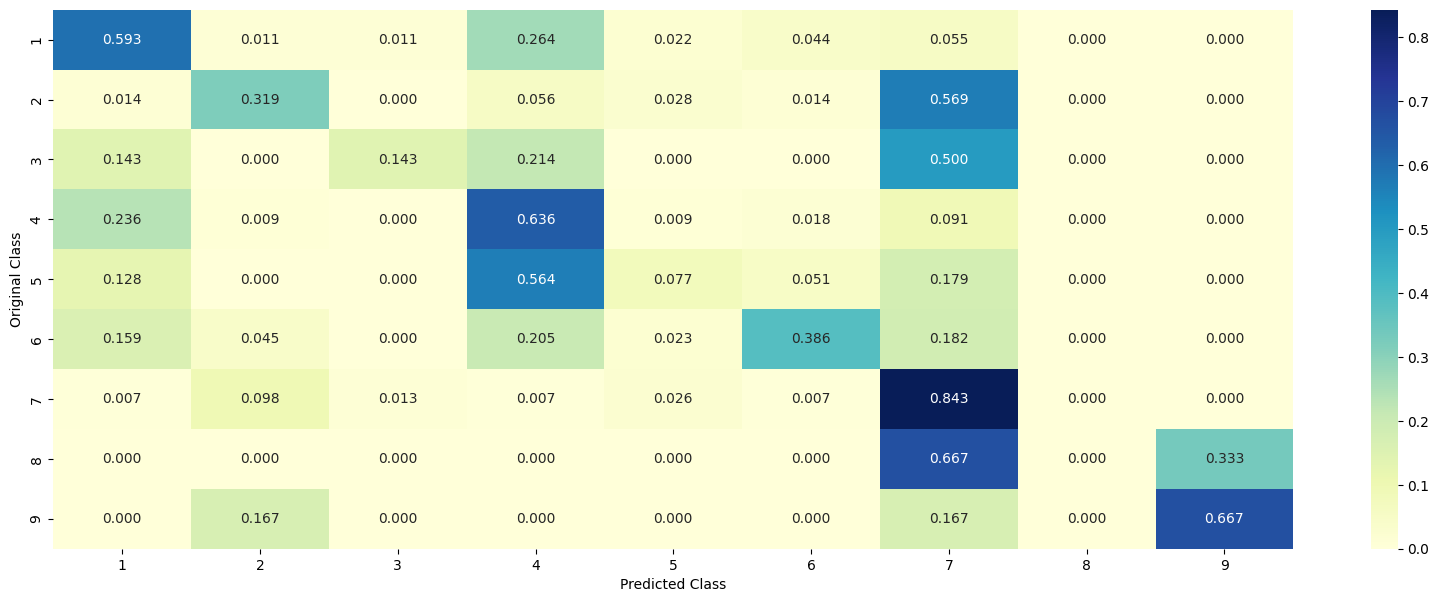

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabirlies we use log-probability estimates
print("Log Loss: ", log_loss(cv_y, sig_clf_probs))
print("Number of missClassified point: ", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)-cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

**Interpretability of our model**

In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]

#list(zip(model.feature_log_prob_[0], cv.get_feature_names()))

print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5194 0.0681 0.0145 0.0859 0.0339 0.0254 0.2435 0.0047 0.0045]]
Actual Class : 4
--------------------------------------------------
11 Text feature [protein] present in test data point [True]
13 Text feature [affect] present in test data point [True]
14 Text feature [reduce] present in test data point [True]
15 Text feature [reduced] present in test data point [True]
16 Text feature [type] present in test data point [True]
17 Text feature [proteins] present in test data point [True]
18 Text feature [therefore] present in test data point [True]
19 Text feature [function] present in test data point [True]
20 Text feature [one] present in test data point [True]
21 Text feature [ability] present in test data point [True]
22 Text feature [binding] present in test data point [True]
23 Text feature [sequence] present in test data point [True]
24 Text feature [acids] present in test data point [True]
25 Text feature [amino] present in test 

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5931 0.0705 0.0151 0.1136 0.0354 0.0279 0.135  0.0049 0.0046]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point


**K Nearest Neighbour Classificaiton**

In [ ]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.8693536646313575
for alpha = 11
Log Loss : 1.548370097242011
for alpha = 15
Log Loss : 1.4714415738991946
for alpha = 21
Log Loss : 1.4302745918681596
for alpha = 31
Log Loss : 1.3438261175740902
for alpha = 41
Log Loss : 1.2711635318580203
for alpha = 51
Log Loss : 1.253810429673373
for alpha = 99
Log Loss : 1.184068713249722


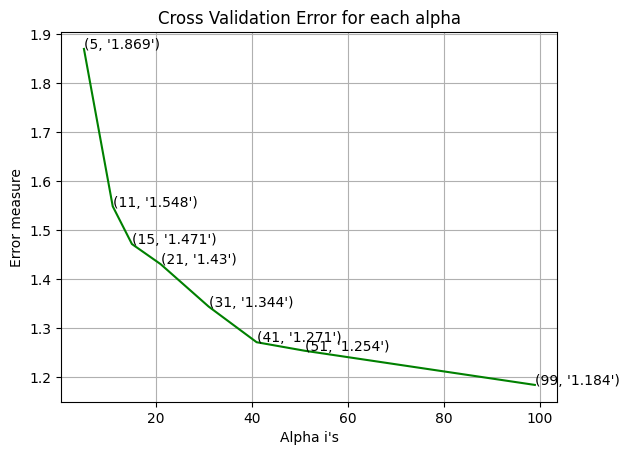

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



For values of best alpha =  99 The train log loss is: 0.9676615991538116
For values of best alpha =  99 The cross validation log loss is: 1.184068713249722
For values of best alpha =  99 The test log loss is: 1.2483323364712564


Log loss : 1.184068713249722
Number of mis-classified points : 0.41353383458646614
-------------------- Confusion matrix --------------------


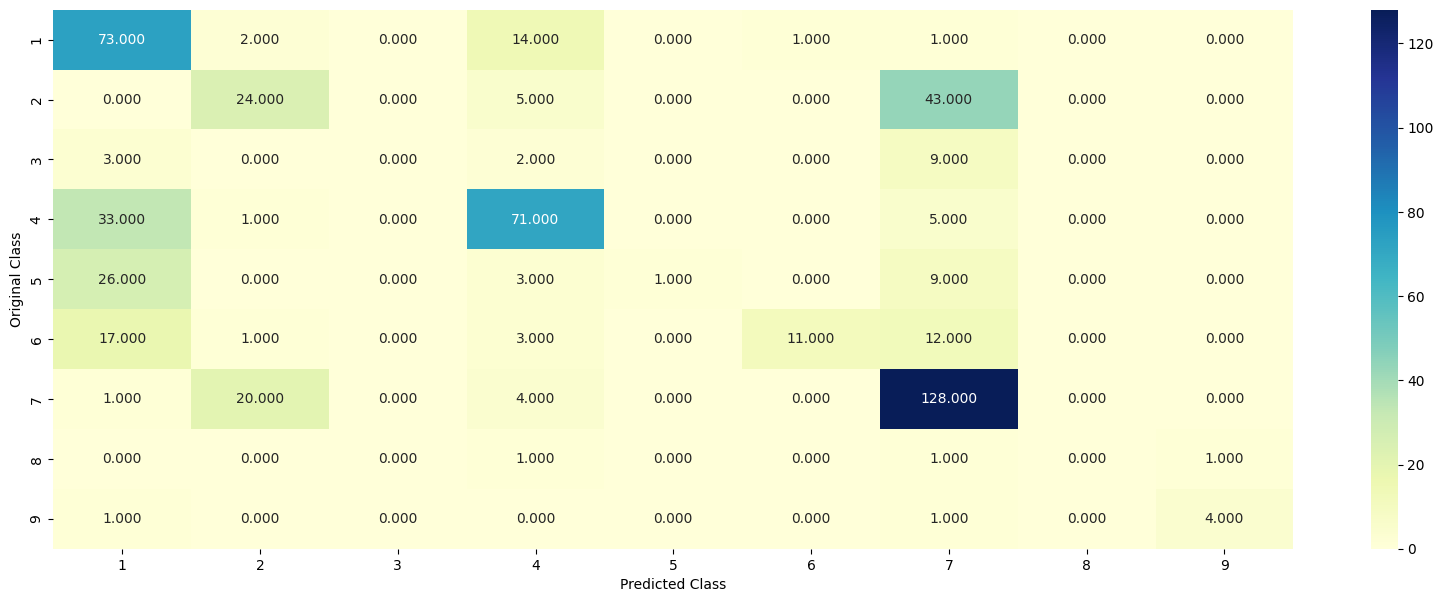

-------------------- Precision matrix (Columm Sum=1) --------------------


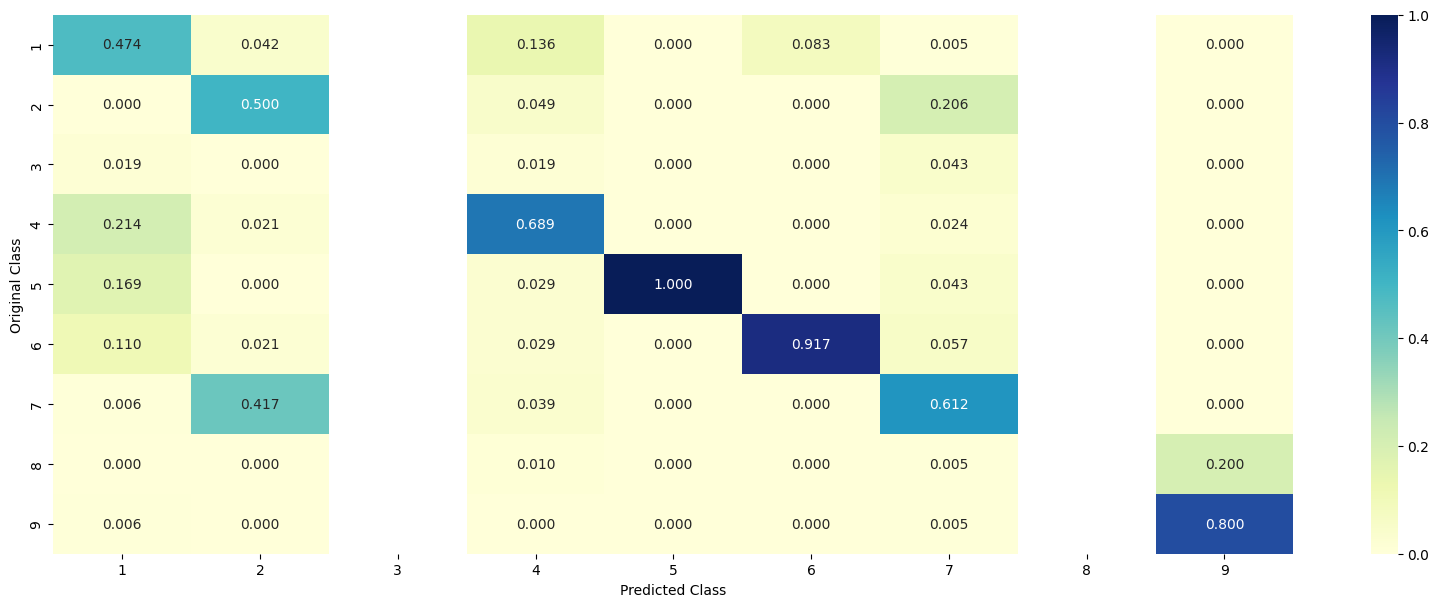

-------------------- Recall matrix (Row sum=1) --------------------


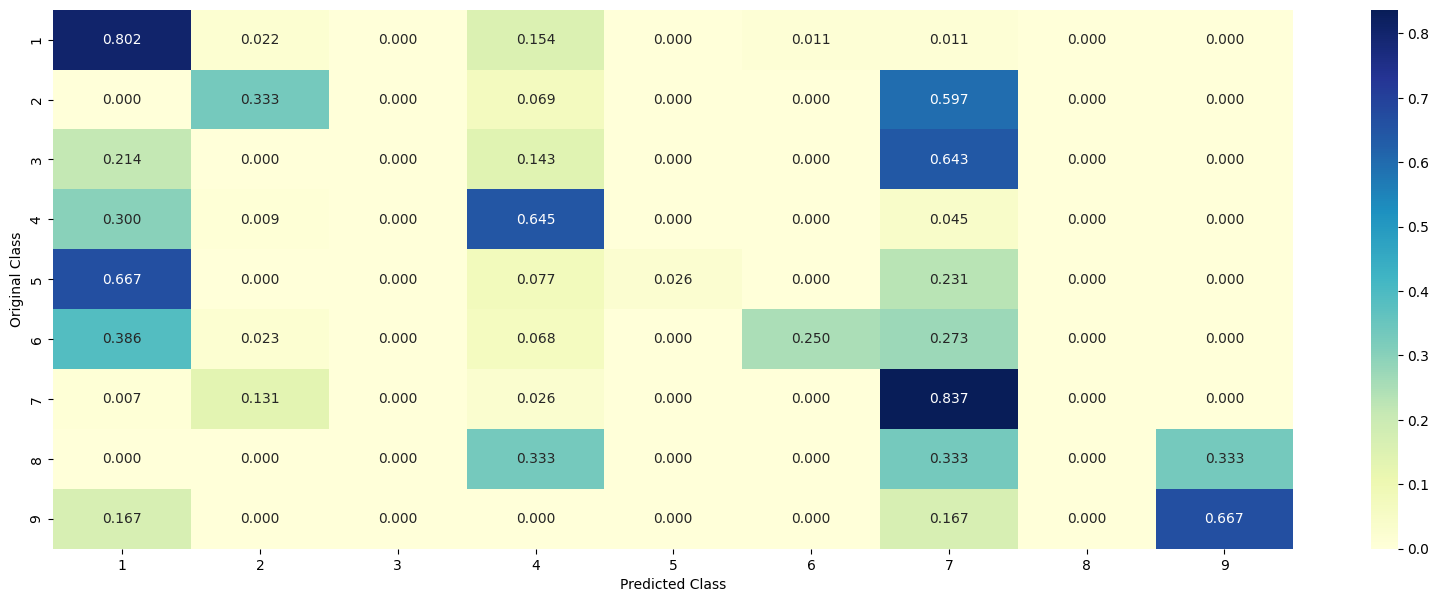

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))


Predicted Class : 4
Actual Class : 1
The  99  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1 1 1 1 4 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Fequency of nearest points : Counter({1: 94, 6: 2, 4: 2, 2: 1})


In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
The  99  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 4 4 4 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 4 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 6 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1]
Fequency of nearest points : Counter({1: 89, 4: 9, 6: 1})


**Logistic Regression**

In [ ]:
# Balancing all classes
alpha = [10**x for x in range(-6,3)]
cv_log_error_array=[]
for i in alpha:
    print("for alpha=",i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(cv_y, sig_clf_probs))

for alpha= 1e-06
The log loss is: 1.6226624671317553
for alpha= 1e-05
The log loss is: 1.5111866022417888
for alpha= 0.0001
The log loss is: 1.282965197720483
for alpha= 0.001
The log loss is: 1.2593793435850096
for alpha= 0.01
The log loss is: 1.3742259238502987
for alpha= 0.1
The log loss is: 1.6333247206169195
for alpha= 1
The log loss is: 1.7457359519439926
for alpha= 10
The log loss is: 1.7570164660238212
for alpha= 100
The log loss is: 1.7581859506817528


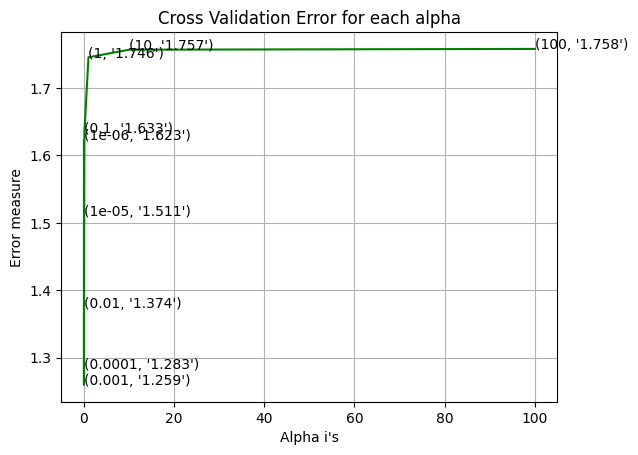

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.7168255052355039
For values of best alpha =  0.001 The cross validation log loss is: 1.2593793435850096
For values of best alpha =  0.001 The test log loss is: 1.3006935691404697


Log loss : 1.2593793435850096
Number of mis-classified points : 0.40225563909774437
-------------------- Confusion matrix --------------------


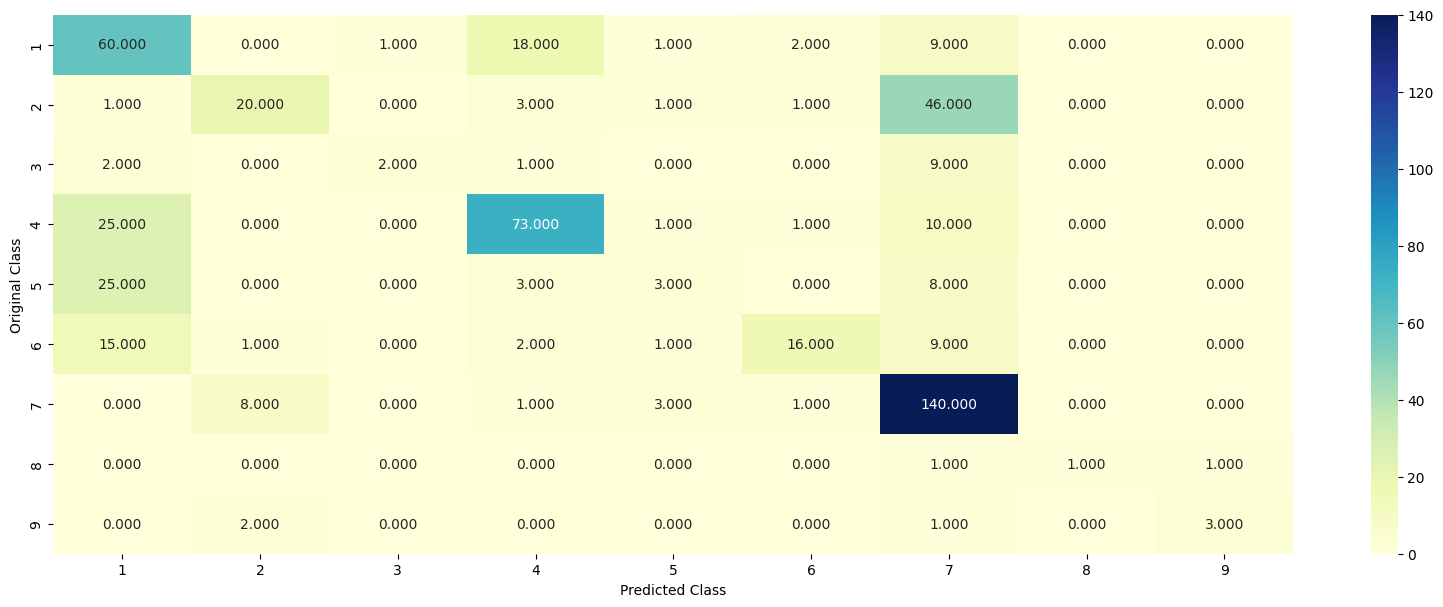

-------------------- Precision matrix (Columm Sum=1) --------------------


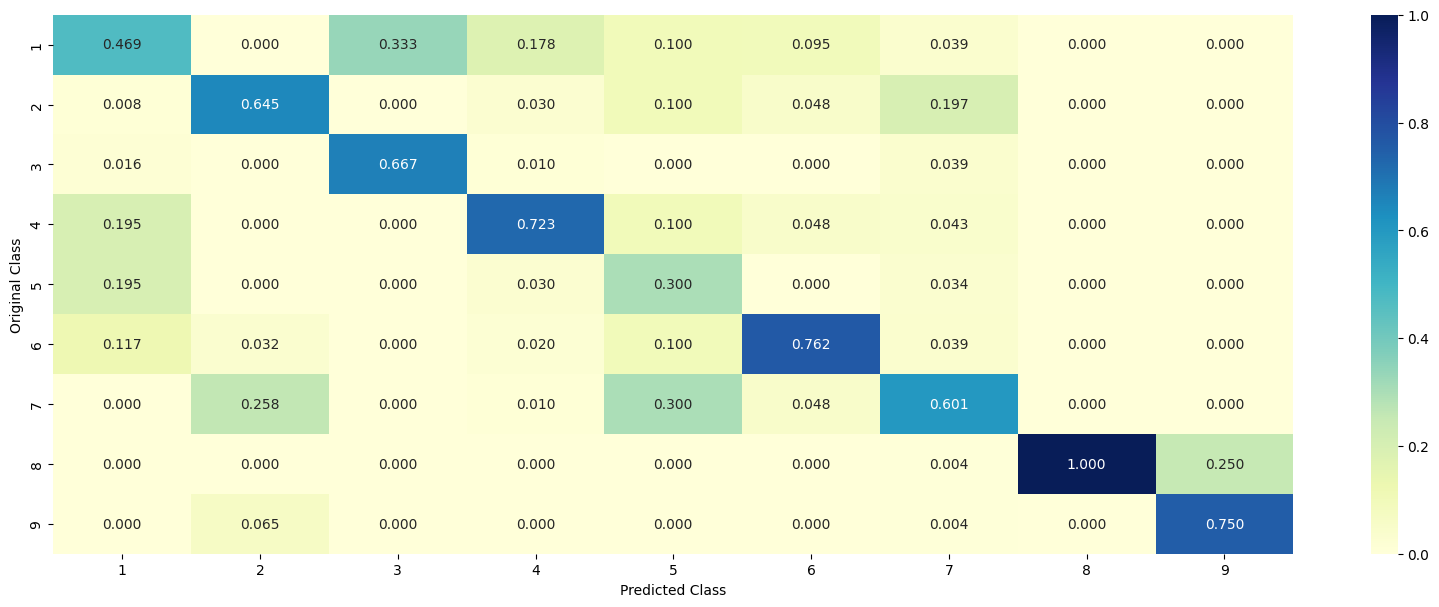

-------------------- Recall matrix (Row sum=1) --------------------


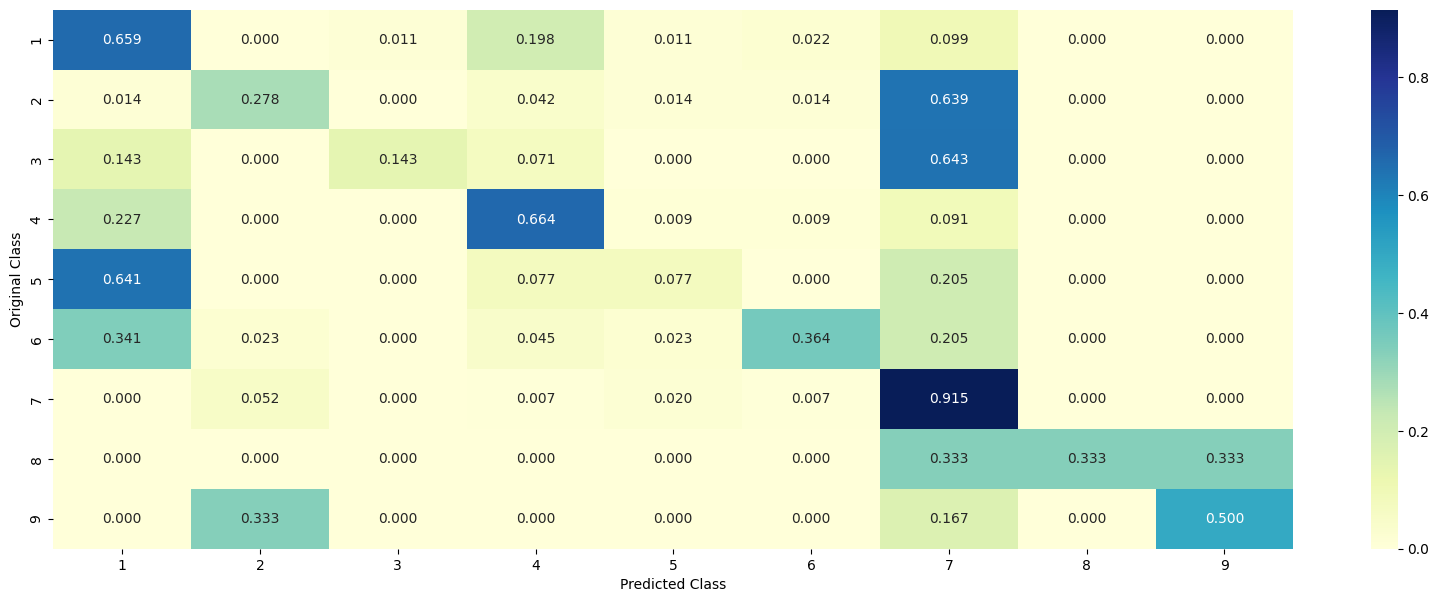

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [ ]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))


In [ ]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6385 0.0678 0.015  0.091  0.0402 0.0486 0.0865 0.006  0.0063]]
Actual Class : 1
--------------------------------------------------
Out of the top  500  features  0 are present in query point


In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.013  0.1711 0.0025 0.0114 0.1367 0.0035 0.6559 0.0036 0.0024]]
Actual Class : 7
--------------------------------------------------
43 Text feature [transforming] present in test data point [True]
111 Text feature [technology] present in test data point [True]
122 Text feature [ligand] present in test data point [True]
148 Text feature [independence] present in test data point [True]
157 Text feature [subcutaneously] present in test data point [True]
185 Text feature [stably] present in test data point [True]
221 Text feature [oncogene] present in test data point [True]
234 Text feature [nude] present in test data point [True]
240 Text feature [activating] present in test data point [True]
246 Text feature [transformation] present in test data point [True]
266 Text feature [murine] present in test data point [True]
270 Text feature [transformed] present in test data point [True]
295 Text feature [egf] present in test data point [Tru

**Without class balancing**

In [ ]:
alpha = [10**x for x in range(-6,1)]
cv_log_error_array=[]
for i in alpha:
    print("for alpha=",i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(cv_y, sig_clf_probs))

for alpha= 1e-06
The log loss is: 1.5835618698000968
for alpha= 1e-05
The log loss is: 1.5141298123925144
for alpha= 0.0001
The log loss is: 1.2904969473787842
for alpha= 0.001
The log loss is: 1.253839752499082
for alpha= 0.01
The log loss is: 1.3655962877420518
for alpha= 0.1
The log loss is: 1.603770531043878
for alpha= 1
The log loss is: 1.7420078351860873


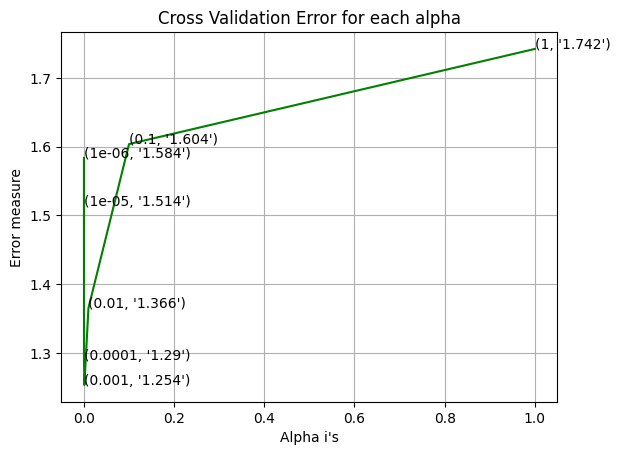

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.7098584444062184
For values of best alpha =  0.001 The cross validation log loss is: 1.253839752499082
For values of best alpha =  0.001 The test log loss is: 1.294791742524025


Log loss : 1.253839752499082
Number of mis-classified points : 0.3966165413533835
-------------------- Confusion matrix --------------------


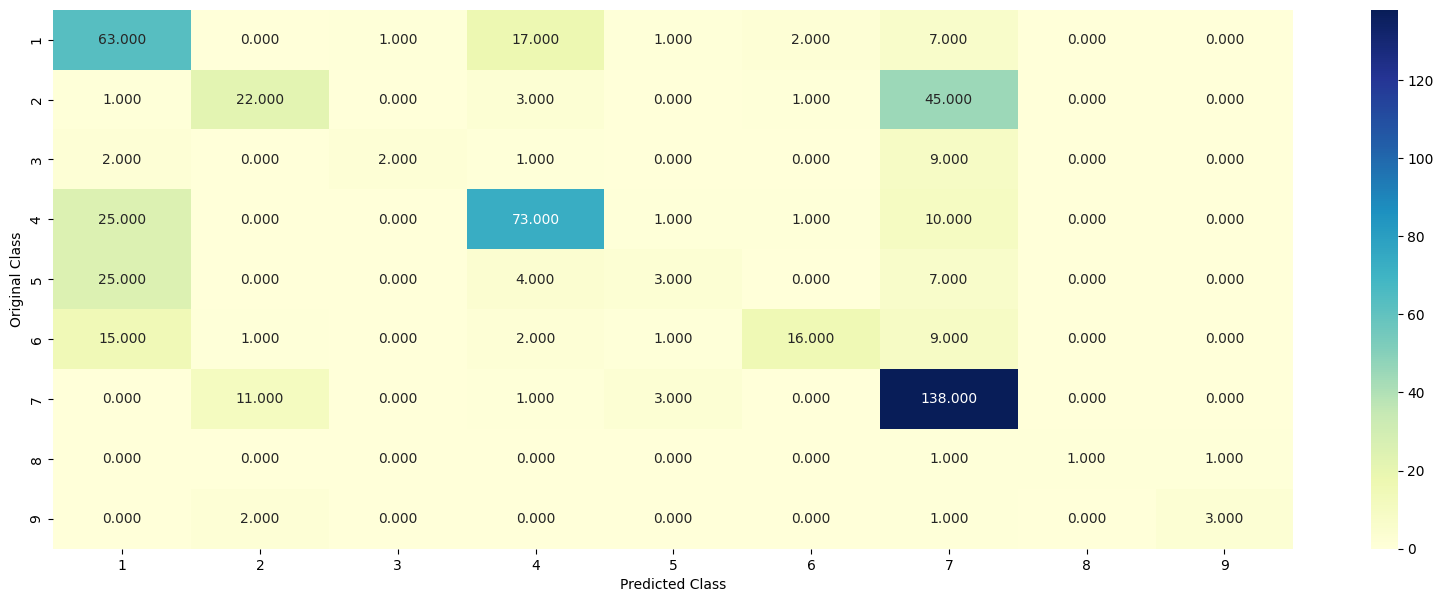

-------------------- Precision matrix (Columm Sum=1) --------------------


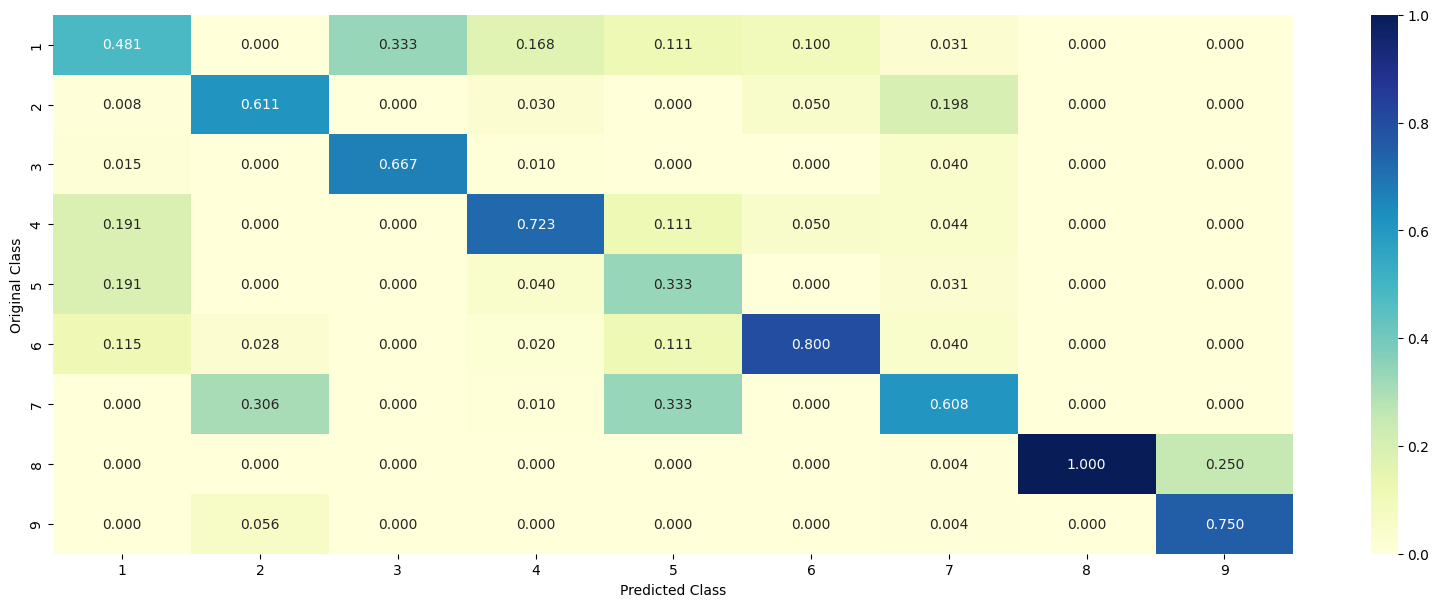

-------------------- Recall matrix (Row sum=1) --------------------


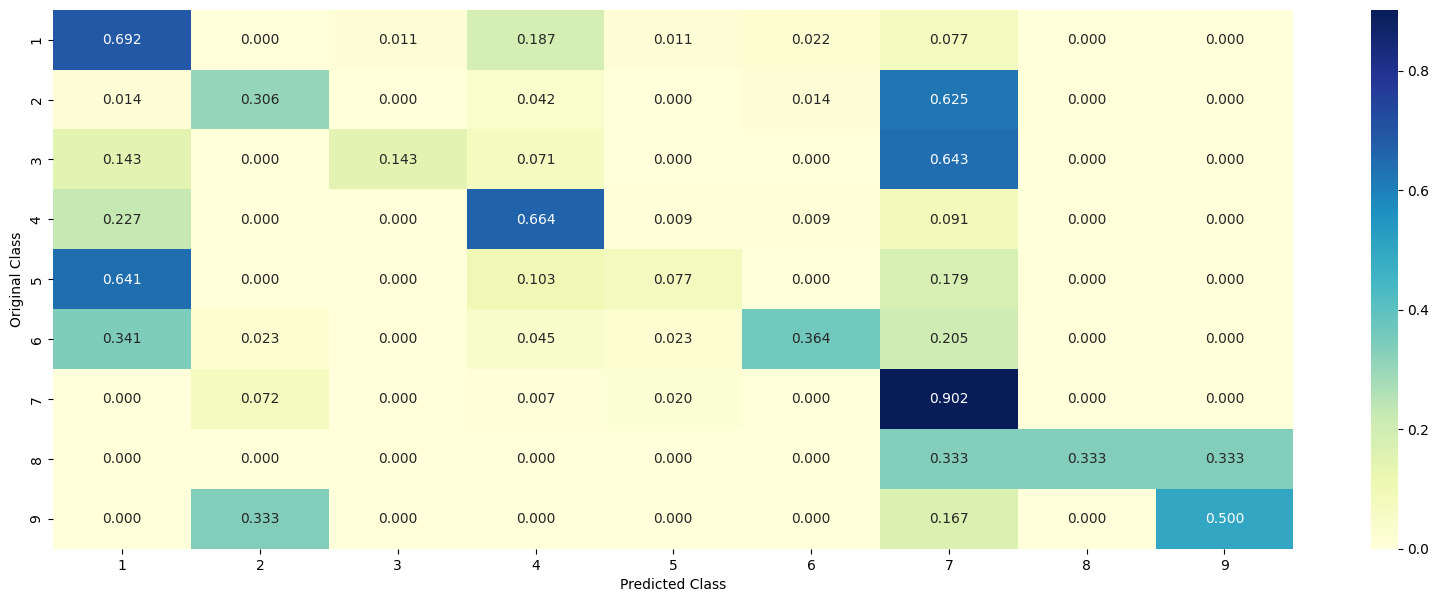

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6412 0.0674 0.0216 0.0818 0.044  0.0507 0.0788 0.0069 0.0078]]
Actual Class : 1
--------------------------------------------------
Out of the top  500  features  0 are present in query point


In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[8.785e-01 2.000e-04 0.000e+00 4.480e-02 0.000e+00 0.000e+00 7.540e-02
  1.100e-03 0.000e+00]]
Actual Class : 4
--------------------------------------------------
170 Text feature [blobe] present in test data point [True]
212 Text feature [heteromeric] present in test data point [True]
288 Text feature [pcdna] present in test data point [True]
299 Text feature [adhesion] present in test data point [True]
305 Text feature [suppressive] present in test data point [True]
322 Text feature [stress] present in test data point [True]
339 Text feature [depth] present in test data point [True]
345 Text feature [pcdna3] present in test data point [True]
368 Text feature [urogenital] present in test data point [True]
377 Text feature [cdh1] present in test data point [True]
410 Text feature [mediates] present in test data point [True]
416 Text feature [compensatory] present in test data point [True]
436 Text feature [smad1] present in test data 

**Linear Support Vector Machines**

In [ ]:
alpha = [10**x for x in range(-5,3)]
cv_log_error_array=[]
for i in alpha:
    print("for C =",i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(cv_y, sig_clf_probs))

for C = 1e-05
The log loss is: 1.5780334773201838
for C = 0.0001
The log loss is: 1.4646560611157342
for C = 0.001
The log loss is: 1.3178113780638583
for C = 0.01
The log loss is: 1.3951573822657612
for C = 0.1
The log loss is: 1.4814363623614706
for C = 1
The log loss is: 1.7542792718561449
for C = 10
The log loss is: 1.7583757272188123
for C = 100
The log loss is: 1.7583734557355375


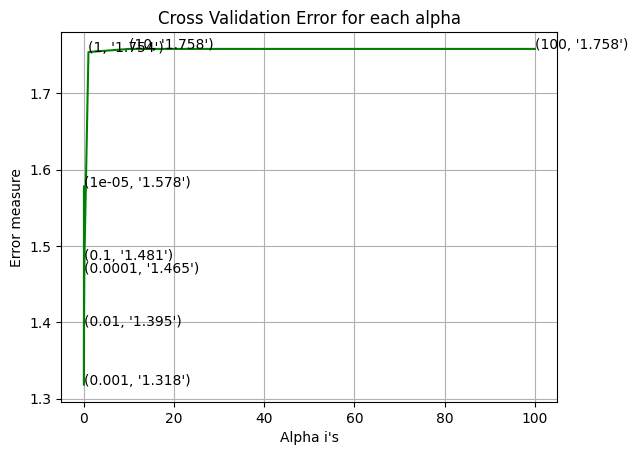

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight = 'balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.748640745354886
For values of best alpha =  0.001 The cross validation log loss is: 1.3178113780638583
For values of best alpha =  0.001 The test log loss is: 1.3683509917107504


Log loss : 1.2685923535915233
Number of mis-classified points : 0.40977443609022557
-------------------- Confusion matrix --------------------


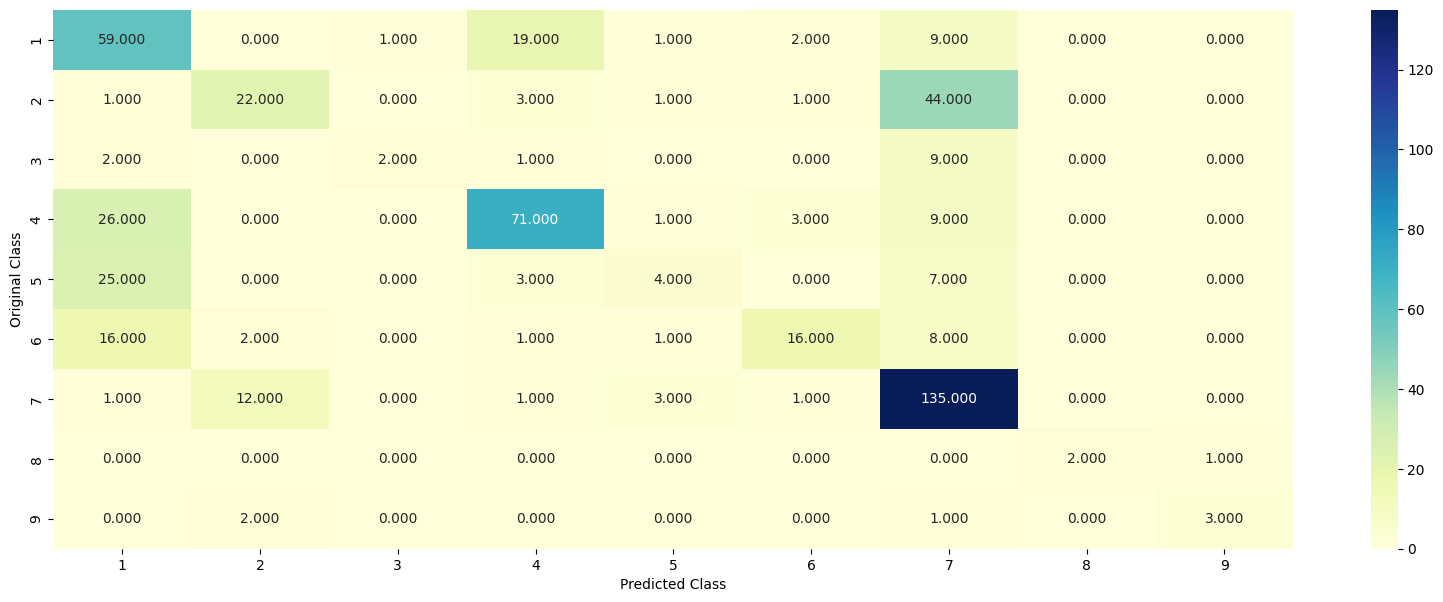

-------------------- Precision matrix (Columm Sum=1) --------------------


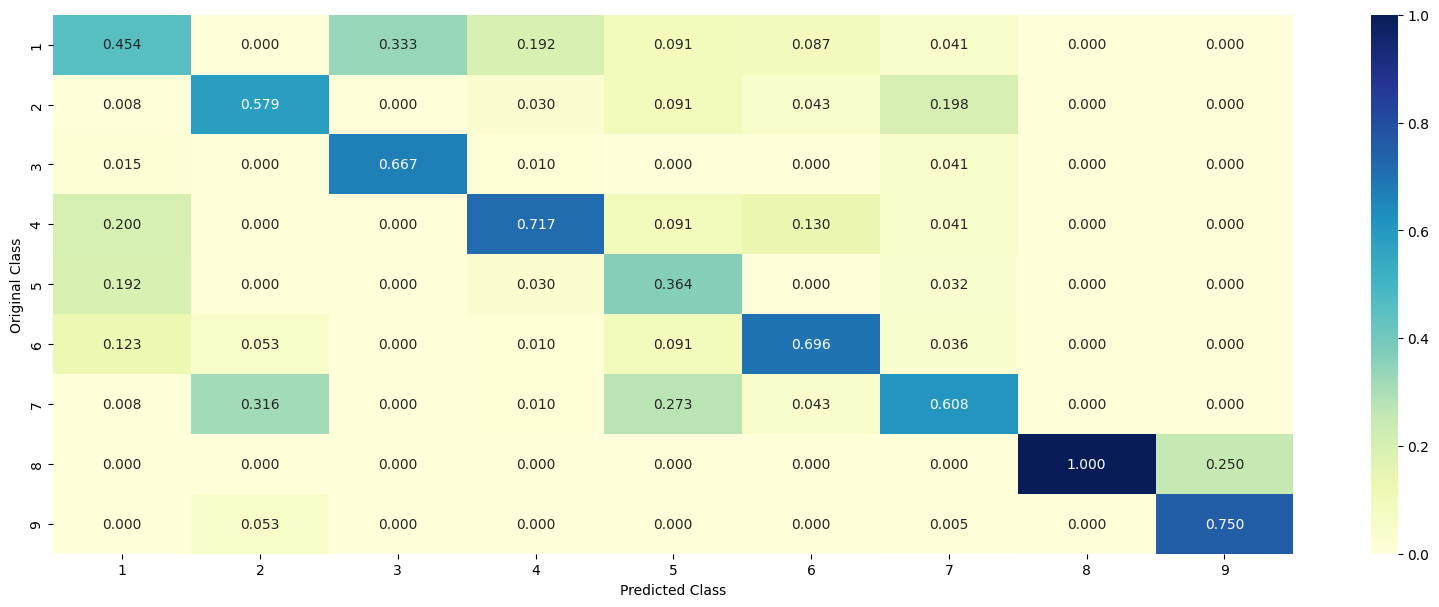

-------------------- Recall matrix (Row sum=1) --------------------


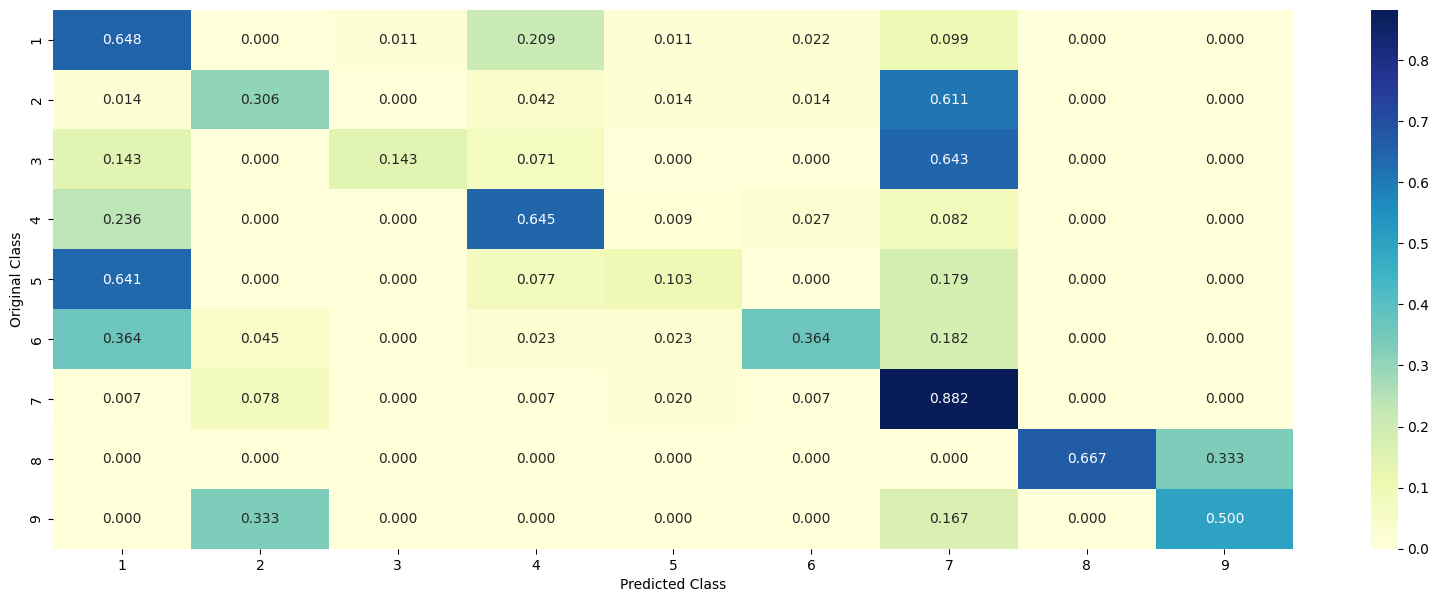

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6549 0.0548 0.0174 0.0568 0.0383 0.0431 0.1242 0.0051 0.0054]]
Actual Class : 1
--------------------------------------------------
Out of the top  500  features  0 are present in query point


In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[7.172e-01 3.800e-03 2.400e-03 6.350e-02 1.800e-03 1.000e-03 2.054e-01
  4.000e-04 4.600e-03]]
Actual Class : 4
--------------------------------------------------
202 Text feature [blobe] present in test data point [True]
222 Text feature [heteromeric] present in test data point [True]
246 Text feature [atypical] present in test data point [True]
261 Text feature [pcdna] present in test data point [True]
313 Text feature [pcdna3] present in test data point [True]
318 Text feature [lag] present in test data point [True]
334 Text feature [smad1] present in test data point [True]
338 Text feature [urogenital] present in test data point [True]
343 Text feature [table1] present in test data point [True]
369 Text feature [k1] present in test data point [True]
430 Text feature [stress] present in test data point [True]
462 Text feature [835] present in test data point [True]
464 Text feature [table11] present in test data point [True]
474 Te

In [ ]:
test_point_index = 50
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0332 0.0546 0.0168 0.0451 0.0113 0.0177 0.8094 0.0022 0.0098]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


**RF with Response Coding**

In [ ]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for n_estimators = 10 and max depth =  2
Log Loss : 2.1246210748074446
for n_estimators = 10 and max depth =  3
Log Loss : 1.836215377577859
for n_estimators = 10 and max depth =  5
Log Loss : 1.7512597800559153
for n_estimators = 10 and max depth =  10
Log Loss : 2.012621242565875
for n_estimators = 50 and max depth =  2
Log Loss : 2.011489950107121
for n_estimators = 50 and max depth =  3
Log Loss : 1.6260426902649032
for n_estimators = 50 and max depth =  5
Log Loss : 1.7138545027224974
for n_estimators = 50 and max depth =  10
Log Loss : 1.9953530878385441
for n_estimators = 100 and max depth =  2
Log Loss : 1.9100239453139591
for n_estimators = 100 and max depth =  3
Log Loss : 1.5805981027696228
for n_estimators = 100 and max depth =  5
Log Loss : 1.5465319190789937
for n_estimators = 100 and max depth =  10
Log Loss : 2.0394606822560593
for n_estimators = 200 and max depth =  2
Log Loss : 1.8164617524988562
for n_estimators = 200 and max depth =  3
Log Loss : 1.6165566118272152


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  100 The train log loss is: 0.06298885234276522
For values of best alpha =  100 The cross validation log loss is: 1.5465319190789937
For values of best alpha =  100 The test log loss is: 1.5218103706994066


Log loss : 1.474696770755869
Number of mis-classified points : 0.5075187969924813
-------------------- Confusion matrix --------------------


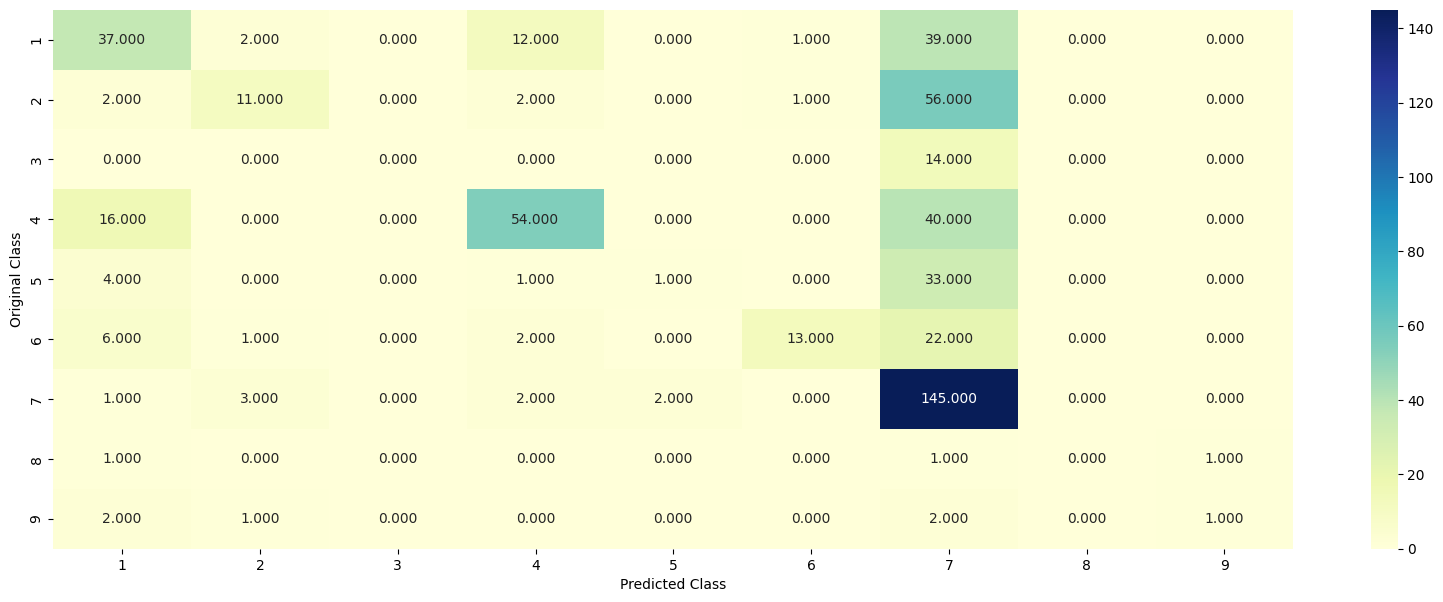

-------------------- Precision matrix (Columm Sum=1) --------------------


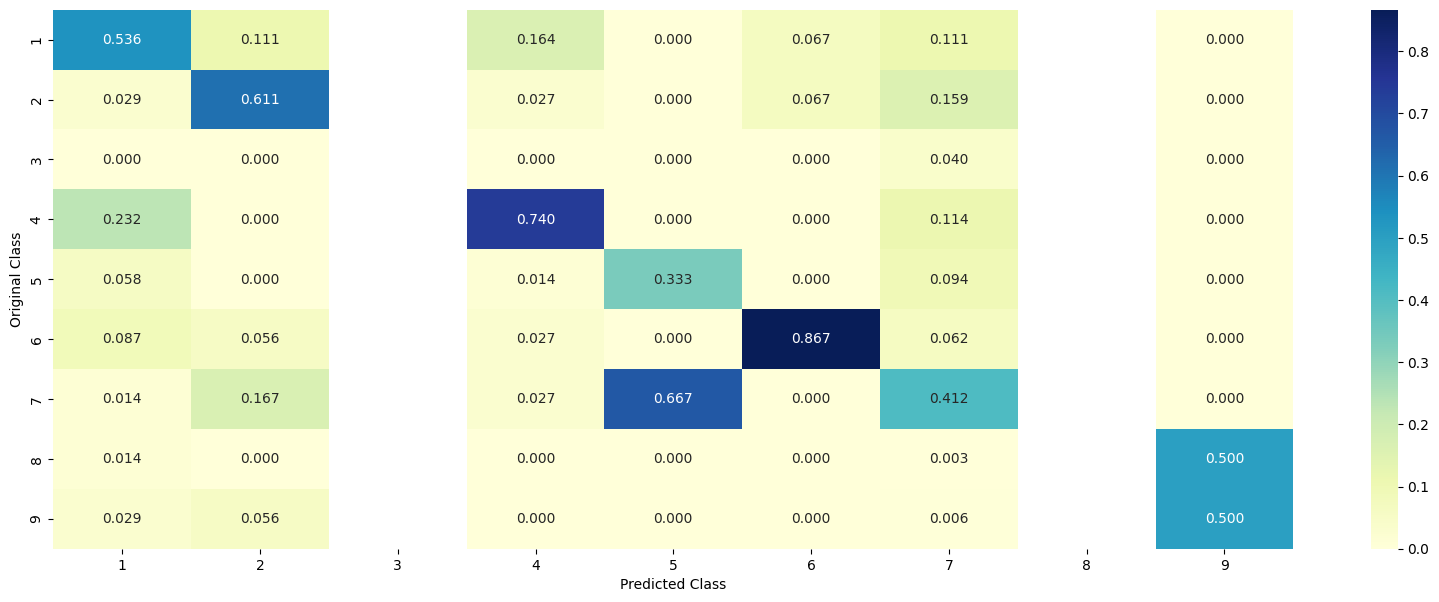

-------------------- Recall matrix (Row sum=1) --------------------


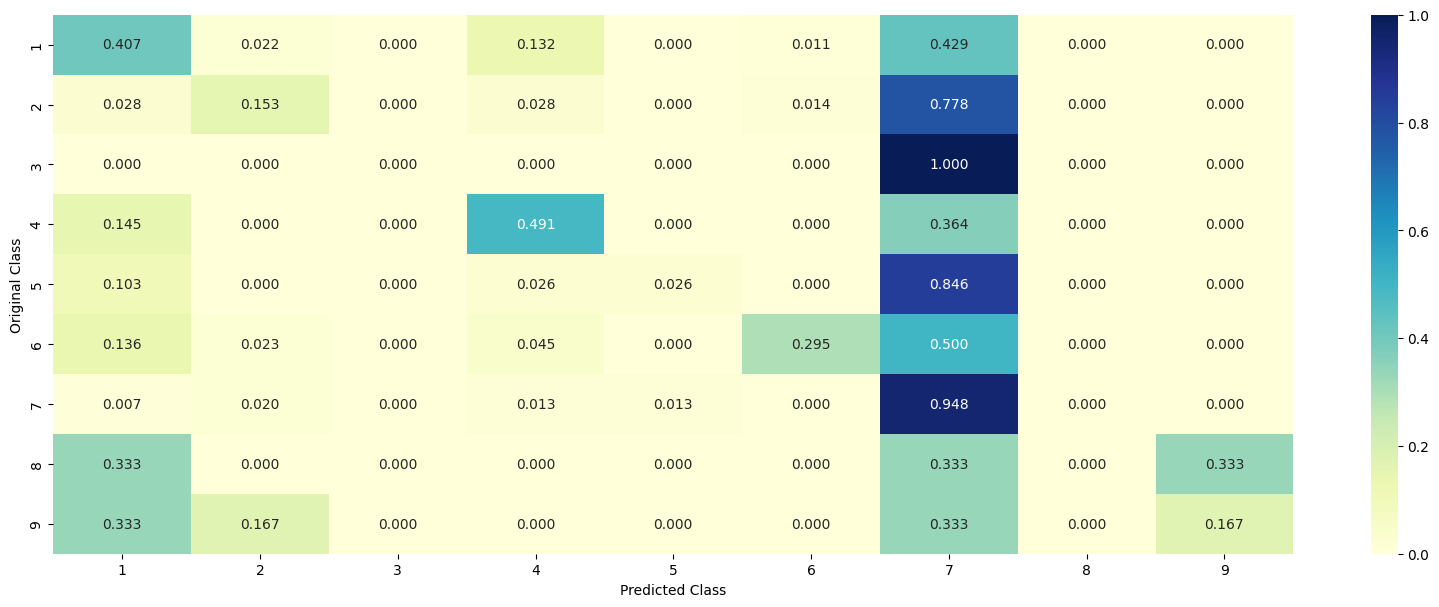

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.9764 0.003  0.0014 0.0054 0.0022 0.0044 0.0021 0.0029 0.0021]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


In [ ]:
test_point_index = 100
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.9309 0.0027 0.0014 0.0524 0.0021 0.0042 0.002  0.0025 0.0019]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature



**Random Forest Classifer**



In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.474696770755869
for n_estimators = 100 and max depth =  10
Log Loss : 1.4535151135026352
for n_estimators = 200 and max depth =  5
Log Loss : 1.4683554575234716
for n_estimators = 200 and max depth =  10
Log Loss : 1.4454387907904864
for n_estimators = 500 and max depth =  5
Log Loss : 1.463772352172051
for n_estimators = 500 and max depth =  10
Log Loss : 1.4325096103624801
for n_estimators = 1000 and max depth =  5
Log Loss : 1.4673647580496114
for n_estimators = 1000 and max depth =  10
Log Loss : 1.4289420250449396
for n_estimators = 2000 and max depth =  5
Log Loss : 1.4684293216615332
for n_estimators = 2000 and max depth =  10
Log Loss : 1.4335928487396916


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  1000 The train log loss is: 1.1450658862339196
For values of best estimator =  1000 The cross validation log loss is: 1.4289420250449396
For values of best estimator =  1000 The test log loss is: 1.4651152867718418


Log loss : 1.4289420250449396
Number of mis-classified points : 0.4548872180451128
-------------------- Confusion matrix --------------------


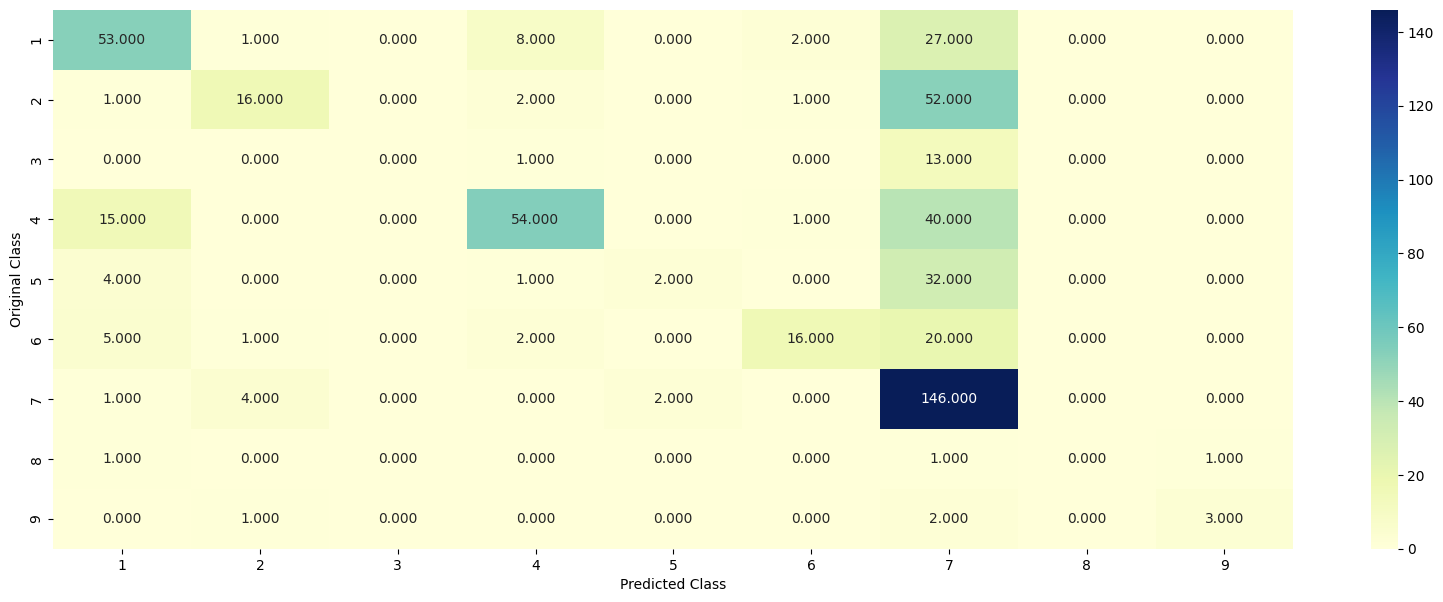

-------------------- Precision matrix (Columm Sum=1) --------------------


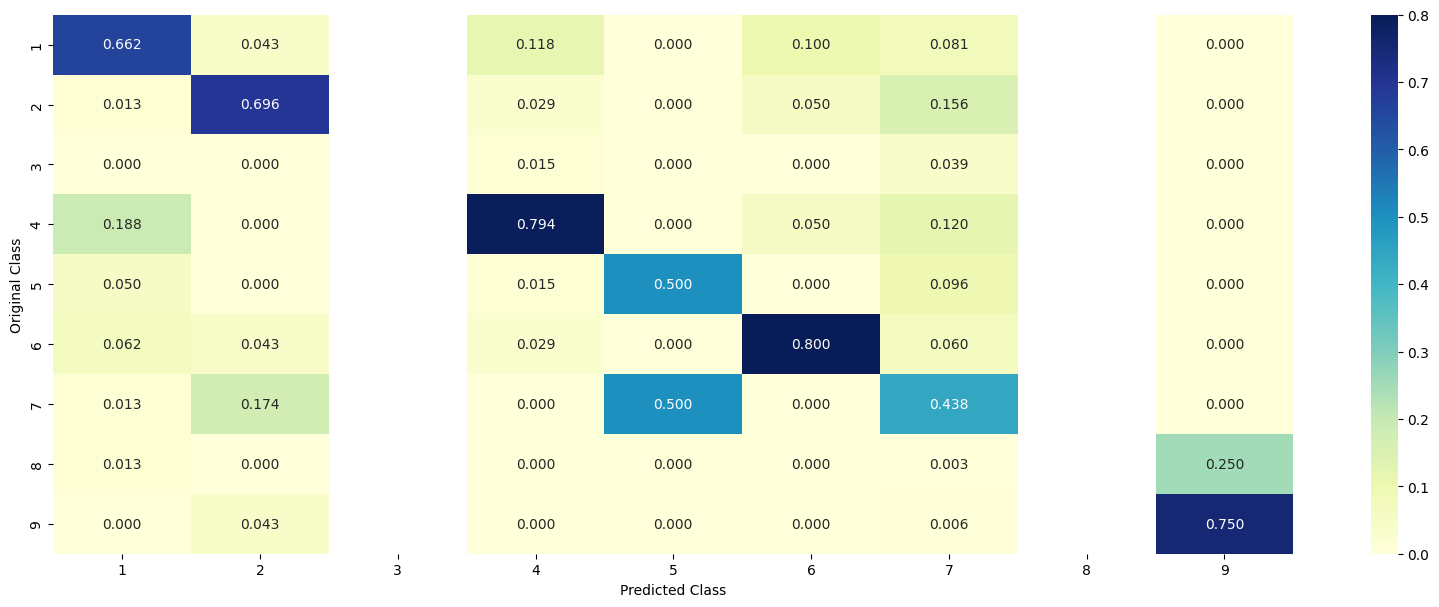

-------------------- Recall matrix (Row sum=1) --------------------


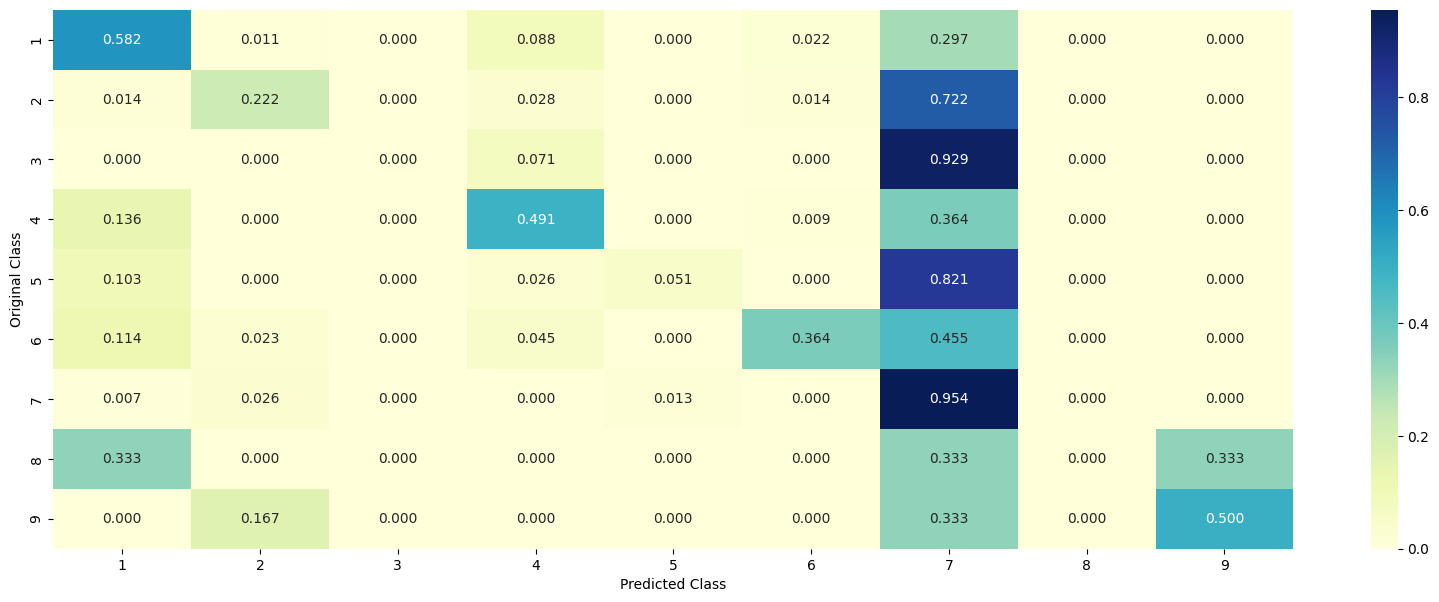

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1906 0.1203 0.0275 0.1781 0.0843 0.0936 0.2915 0.007  0.0071]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point


**Stacking model**

In [ ]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error


Logistic Regression :  Log Loss: 1.25
Support vector machines : Log Loss: 1.75
Naive Bayes : Log Loss: 1.33
--------------------------------------------------


NameError: ignored

In [ ]:
#Testing with the best hyper param
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

**Maximum Voting Classifier**

In [ ]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators = [('lr', sig_clf1),('svc', sig_clf2),('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the  Votingclassifier :",log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (cv) on the  Votingclassifier :",log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the  Votingclassifier :",log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))

print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))